Spatial step size: 20.0
Time step size: 0.06
Number of time steps: 8
Number of spatial steps: 5, 5


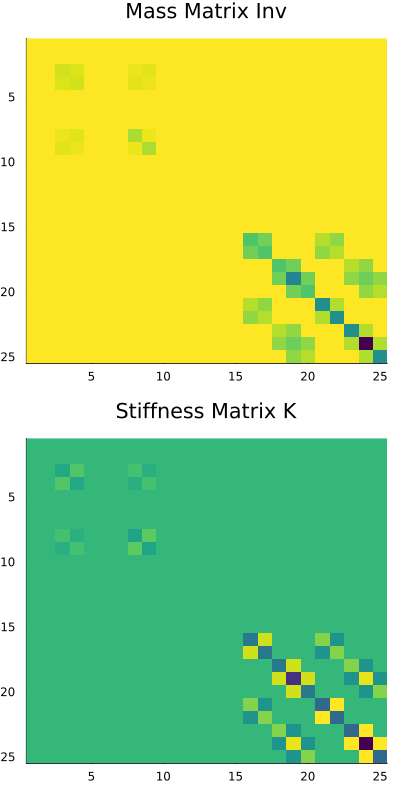

In [35]:
using LinearAlgebra
using Plots
using SparseArrays

# Basic parameters
vs = 100.0  # Wave velocity [m/s]
f = 0.5  # Central frequency of the source (in Hz)
λ = vs / f  # Wavelength

# Spatial and temporal parameters based on CFL condition
ep = 0.3  # Stability limit
dx = 0.1 * λ  # Spatial step size
dx_min = dx
dt = ep * dx / vs  # Time step size based on CFL

t_max = 0.5  # Maximum simulation time (in seconds)
x_max = 100.0  # Maximum spatial coordinate (in meters)

# Print information
println("Spatial step size: $dx")
println("Time step size: $dt")

# Calculate number of steps
nt = round(Int, t_max / dt)
nx = round(Int, x_max / dx)
ny = nx  # Assuming square domain for 2D
println("Number of time steps: $nt")
println("Number of spatial steps: $nx, $ny")

# Initialize spatial coordinates
elem = zeros(nx,ny)

for i in 1:nx
    for j in 1:ny
        elem[i,j] = (i-1)*nx + j
    end
end


# parameters physical
ro0 = 1500    # Density [kg/m^3]
ro = elem * 0 .+ ro0          # initialize density array
young_mod = elem * 0 .+ ro .* vs .^ 2   # calculate young modulus from density and velocity

# Time axis
t = range(dt, stop=nt * dt, length=nt)

# Source term (simple Ricker wavelet)
function ricker_wavelet(t, f, tau=2.0)
    # A = (1 - 2 * π^2 * f^2 * (t - tau)^2)
    # wavelet = A * exp(-π^2 * f^2 * (t - tau)^2)
    wavelet = sin(2 * π * f * (t - tau)) * exp(-π^2 * f^2 * (t - tau)^2)
    return wavelet
end

function bilinear_basis(xi, yi)
  return [(1 - xi) * (1 - yi) / 4, (1 + xi) * (1 - yi) / 4, (1 + xi) * (1 + yi) / 4, (1 - xi) * (1 + yi) / 4]
end

function jacobian(x1, x2, y1, y2)
  # Calculate basis function values at each point
  b11 = (1 - x1 / (x2 - x1)) * (1 - y1 / (y2 - y1)) / 4
  b12 = (1 + x1 / (x2 - x1)) * (1 - y1 / (y2 - y1)) / 4
  b21 = (1 + x1 / (x2 - x1)) * (1 + y1 / (y2 - y1)) / 4
  b22 = (1 - x1 / (x2 - x1)) * (1 + y1 / (y2 - y1)) / 4

  # Define Jacobian matrix
  J = zeros(2, 2)
  J[1, 1] = (b22 - b12) / (x2 - x1)
  J[1, 2] = (b21 - b11) / (y2 - y1)
  J[2, 1] = (b12 - b22) / (x2 - x1)
  J[2, 2] = (b11 - b21) / (y2 - y1)

  return J
end

function gauss_legendre_quadrature()
  # Define quadrature points and weights for 2d
  points = [
    (-sqrt((3 / 7) - ((2 / 7) * sqrt(6 / 5))), -sqrt((3 / 7) - ((2 / 7) * sqrt(6 / 5)))),
    (sqrt((3 / 7) - ((2 / 7) * sqrt(6 / 5))), -sqrt((3 / 7) - ((2 / 7) * sqrt(6 / 5)))),
    (-sqrt((3 / 7) + ((2 / 7) * sqrt(6 / 5))), sqrt((3 / 7) + ((2 / 7) * sqrt(6 / 5)))),
    (sqrt((3 / 7) + ((2 / 7) * sqrt(6 / 5))), sqrt((3 / 7) + ((2 / 7) * sqrt(6 / 5))))
  ]

  weights = [(18 + sqrt(30)) / 36, (18 + sqrt(30)) / 36, (18 - sqrt(30)) / 36, (18 - sqrt(30)) / 36]

  return points, weights
end


function mass_matrix(x1, x2, y1, y2, ro, A=1.0)
  points, weights = gauss_legendre_quadrature()

  M = spzeros(4, 4)  # Assuming bilinear elements, hence 4x4 mass matrix

  for k in 1:4
    xi, yi = points[k]
    w = weights[k]

    basis_values = bilinear_basis(xi, yi)

    for i in 1:4
      for j in 1:4
        M[i, j] += w * basis_values[i] * basis_values[j] * ro * A * det(jacobian(x1, x2, y1, y2))
      end
    end
  end

  return M
end

function stiffness_matrix(x1, x2, y1, y2, young_mod)
  points, weights = gauss_legendre_quadrature()

  num_nodes = 4
  K = spzeros(num_nodes, num_nodes)  # Assuming bilinear elements, hence 4x4 stiffness matrix

  bilinear_basis_derivatives(xi, yi) = [-0.25 * (1 - yi) / (x2 - x1), 0.25 * (1 - yi) / (x2 - x1), 0.25 * (1 + yi) / (x2 - x1), -0.25 * (1 + yi) / (x2 - x1)]

  for k in 1:4
    xi, yi = points[k]
    w = weights[k]

    basis_derivatives = bilinear_basis_derivatives(xi, yi)

    for i in 1:4
      for j in 1:4
        K[i, j] += w * basis_derivatives[i] * basis_derivatives[j] * young_mod * det(jacobian(x1, x2, y1, y2))
      end
    end

  end

  return K
end

function global_matrix(elem, ro, young_mod)
  num_elements = (size(elem, 1)) * (size(elem, 2))  # Assuming a regular grid

  M_global = spzeros(num_elements, num_elements)
  K_global = spzeros(num_elements, num_elements)

  for i in 1:size(elem, 1)-1
    for j in 1:size(elem, 2)-1
      x1, y1 = elem[i, j], elem[i, j+1]
      x2, y2 = elem[i+1, j], elem[i+1, j+1]

      M_e = mass_matrix(x1, x2, y1, y2, ro[i, j])
      K_e = stiffness_matrix(x1, x2, y1, y2, young_mod[i, j])

      # make indices with type Int
      indices = [Int(x1), Int(y1), Int(x2), Int(y2)]
      indicesMap = Dict(indices[i] => i for i in 1:length(indices))
      # println(indices)

      for k in 1:4
        for l in 1:4
          M_global[indices[k], indices[l]] += M_e[k, l]
          K_global[indices[k], indices[l]] += K_e[k, l]
        end
      end

    end
  end

  return M_global, K_global
end


# Invert M using pseudoinverse
mass_matrices, stiffness_matrices = global_matrix(elem, ro, young_mod)
mass_matrices = transpose(mass_matrices)
stiffness_matrices = transpose(stiffness_matrices)


# for i in 1:size(elem, 1)
#     println(elem[i, :])
# end


# Time stepping function
function time_step(elem, young_mod, ro, t_max, dt)
  M, K = global_matrix(elem, ro, young_mod)
  num_elements = (size(elem, 1)) * (size(elem, 2))  # Assuming a regular grid

  u = spzeros(num_elements, num_elements)
  uOld = copy(u)

  Minv = pinv(M)
  timeSeries =  0:dt:t_max
  uTime = spzeros(length(timeSeries), num_elements, num_elements)

  for (i, t) in enumerate(timeSeries)
    # Source term
    F = spzeros(num_elements, num_elements)
    F[1, 1] = ricker_wavelet(t, f)

    # Time stepping
    unew = dt^2 * M_inv * (F - K * u) + 2 * u - uold

    uold, u = u, unew
    u_time[it, :] = u

  end

end

# Plot mass matrix and stiffness matrix in one plot
plot(
  heatmap(mass_matrices, title="Mass Matrix Inv", color=:viridis, legend=false, yflip=true),
  heatmap(stiffness_matrices, title="Stiffness Matrix K", color=:viridis, legend=false, yflip=true),
  layout=(2, 1), size=(400, 800)
)

In [37]:
u_time = time_step(elem, young_mod, ro, t_max, dt)

max_u = maximum(u_time)
min_u = minimum(u_time)

# println(u_time[nt, :])

# display
anim = @animate for it in 1:nt
    #     # if it % iplot == 0
    IJulia.clear_output(true)
    p = heatmap(x, u_time[it, :], legend=true, title="time: $(it*dt) s", label="wave", ylims=(min_u, max_u), xlabel=("x (m)"), ylabel="Amplitude (m)")
    display(p)
    #     # end

    # break if u too large
    if maximum(u_time[it, :]) > 1e10
        break
    end
end

gif(anim, "elastic_wave-fem-2d.gif", fps=20)

LoadError: MethodError: no method matching svd!(::SparseMatrixCSC{Float64, Int64}; full::Bool, alg::LinearAlgebra.DivideAndConquer)

[0mClosest candidates are:
[0m  svd!([91m::LinearAlgebra.AbstractTriangular[39m; kwargs...)
[0m[90m   @[39m [36mLinearAlgebra[39m [90mC:\Users\faliq\AppData\Local\Programs\Julia-1.9.3\share\julia\stdlib\v1.9\LinearAlgebra\src\[39m[90m[4mtriangular.jl:2419[24m[39m
[0m  svd!([91m::StridedMatrix{T}[39m; full, alg) where T<:Union{Float32, Float64, ComplexF32, ComplexF64}
[0m[90m   @[39m [36mLinearAlgebra[39m [90mC:\Users\faliq\AppData\Local\Programs\Julia-1.9.3\share\julia\stdlib\v1.9\LinearAlgebra\src\[39m[90m[4msvd.jl:100[24m[39m
[0m  svd!([91m::StridedVector{T}[39m; full, alg) where T<:Union{Float32, Float64, ComplexF32, ComplexF64}
[0m[90m   @[39m [36mLinearAlgebra[39m [90mC:\Users\faliq\AppData\Local\Programs\Julia-1.9.3\share\julia\stdlib\v1.9\LinearAlgebra\src\[39m[90m[4msvd.jl:109[24m[39m
[0m  ...


In [38]:
# Array asli
nTest = 4
original_array = zeros(nTest, nTest)

for i in 1:nTest
    for j in 1:nTest
        original_array[i, j] = (i-1)*nTest + j
    end
end


# for i in 1:size(original_array, 1)
#     println(original_array[i, :])
# end

# println(size(elem, 2))
# println(size(original_array, 2))

# Membuat array yang diinginkan
function generateGlobalArr(original_array)
    result_array = []

    for i in 1:(size(original_array, 1)-1)
        for j in 1:(size(original_array, 2)-1)
            sub_array = [
                original_array[i, j],
                original_array[i, j+1],
                original_array[i+1, j],
                original_array[i+1, j+1]
            ]
            push!(result_array, sub_array)
        end
    end

    return result_array
end

result_array = generateGlobalArr(original_array)

# Menampilkan hasil
for sub_array in result_array
    println(sub_array)
end


[1.0, 2.0, 5.0, 6.0]
[2.0, 3.0, 6.0, 7.0]
[3.0, 4.0, 7.0, 8.0]
[5.0, 6.0, 9.0, 10.0]
[6.0, 7.0, 10.0, 11.0]
[7.0, 8.0, 11.0, 12.0]
[9.0, 10.0, 13.0, 14.0]
[10.0, 11.0, 14.0, 15.0]
[11.0, 12.0, 15.0, 16.0]


In [ ]:
# Define elements (each element i a quadriteral defined by 4 node indices)
elements = [
    (1, 2, 5, 4),
    (2, 3, 6, 5),
    (4, 5, 8, 7),
    (5, 6, 9, 8)
]

# Assembly process
for element in elements
    for i in l:4
        for j in l:4
            global_mass_matrix[element[i], element[j]] += local_mass_matrix[i, j]
            global_stifness_matrix[element[i], element[j]] += local_stifness_matrix[i, j]
        end
    end
end

# Display the global matrices
println("Global Mass Matrix:")
println(global_mass_matrix)

println("\nGlobal Stifness Matrix")
println(global_stifness_matrix)